# Projet ia 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mido import MidiFile, MidiTrack, Message, MetaMessage
from scipy import linalg
from ipywidgets import *
from IPython.display import *
import os

#Pour afficher les courbes dans le notebook
%matplotlib inline

## Import des notes du fichier midi désiré

In [115]:
noteon = []
note=[]
duree=[]
musiclist = os.listdir('midi-classique-flute')

#importation du fichier midi désiré
for musicfile in musiclist:
    mid = MidiFile('midi-classique-flute/[Free-scores.com]_ali-choobdar-night-the-lotus-66972.midi')
    #newfile = 'midi-classique-flute/' + musicfile
    #newfile = 'midi-classique-flute/' + musicfile
    #print(newfile)
    #mid = MidiFile(newfile)
    for i, track in enumerate(mid.tracks):
        for msg in track:
            if msg.type == 'note_on':
                newNote = (msg.note,msg.time)
                #on ajoute chaque note dans le tableau noteon (hauteur + durée)
                noteon.append(newNote)
                note.append(msg.note)
                duree.append(msg.time)
    print(noteon)


[(76, 49), (65, 40), (67, 494), (69, 486), (70, 469), (76, 17), (74, 40), (67, 40), (69, 44), (70, 40), (74, 40), (81, 44), (62, 27), (64, 40), (65, 40), (78, 44), (70, 40), (69, 40), (65, 40), (64, 40), (72, 44), (74, 1046), (75, 984), (62, 70), (74, 40), (62, 44), (64, 40), (65, 40), (78, 44), (70, 40), (69, 40), (65, 40), (64, 40), (72, 44), (74, 1046), (75, 984), (62, 70), (74, 40), (70, 44), (65, 44), (67, 40), (72, 40), (69, 40), (66, 44), (64, 1046), (60, 984), (62, 70), (77, 44), (76, 40), (72, 40), (74, 40), (69, 40), (69, 5), (67, 40), (65, 40), (64, 40), (66, 40), (67, 40), (79, 44), (72, 40), (70, 40), (62, 44), (64, 40), (66, 40), (62, 44), (62, 27), (64, 1046), (65, 984), (70, 70), (79, 44), (76, 40), (74, 40), (81, 44), (82, 40), (79, 40), (77, 44), (76, 40), (78, 40), (67, 44), (65, 1046), (64, 984), (67, 70), (65, 40), (65, 1), (68, 40), (79, 44), (77, 40), (76, 40), (74, 40), (66, 40), (67, 40), (64, 44), (62, 40), (66, 40), (64, 44), (62, 1046), (65, 70), (67, 1046),

[(76, 49), (65, 40), (67, 494), (69, 486), (70, 469), (76, 17), (74, 40), (67, 40), (69, 44), (70, 40), (74, 40), (81, 44), (62, 27), (64, 40), (65, 40), (78, 44), (70, 40), (69, 40), (65, 40), (64, 40), (72, 44), (74, 1046), (75, 984), (62, 70), (74, 40), (62, 44), (64, 40), (65, 40), (78, 44), (70, 40), (69, 40), (65, 40), (64, 40), (72, 44), (74, 1046), (75, 984), (62, 70), (74, 40), (70, 44), (65, 44), (67, 40), (72, 40), (69, 40), (66, 44), (64, 1046), (60, 984), (62, 70), (77, 44), (76, 40), (72, 40), (74, 40), (69, 40), (69, 5), (67, 40), (65, 40), (64, 40), (66, 40), (67, 40), (79, 44), (72, 40), (70, 40), (62, 44), (64, 40), (66, 40), (62, 44), (62, 27), (64, 1046), (65, 984), (70, 70), (79, 44), (76, 40), (74, 40), (81, 44), (82, 40), (79, 40), (77, 44), (76, 40), (78, 40), (67, 44), (65, 1046), (64, 984), (67, 70), (65, 40), (65, 1), (68, 40), (79, 44), (77, 40), (76, 40), (74, 40), (66, 40), (67, 40), (64, 44), (62, 40), (66, 40), (64, 44), (62, 1046), (65, 70), (67, 1046),

# Utilisation du code de Word generator 

In [83]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen
        # données d'entrée :
        self.input_text = noteon #The one to keep
        self.resSize = 300
        self.a = 0.3
        self.spectral_radius = 1.25
        self.input_scaling = 1.
        self.reg =  1e-8
        self.mode = 'prediction'
        seed = None #42
        set_seed(seed)
        
nw = Network()

2068254295
('Seed used for random values:', 2068254295)


Fonction permettant de définir les entrées et sorties de notre réseau de neurone 

In [84]:
def notes(nw) :
    nw.input_units, nw.output_units = dict(), dict()
    for i, item in enumerate(set(nw.input_text)) : nw.input_units[item] = i
    for i, item in enumerate(set(nw.input_text)) : nw.output_units[i] = item
    print("\nExisting notes in the music :", sorted(nw.input_units),
          "\nNumber of different notes :", len(nw.input_units), "\n")
    return(nw)

Code Word generator 

In [85]:
def convert_input(nw) :
    print("Converting input into ID numbers...")
    nw.data = np.array([nw.input_units[i] for i in nw.input_text])
    print(nw.data)
    nw.inSize = nw.outSize = len(nw.input_units)
    print("done.")
    return(nw)

In [86]:
def binary_data(nw) :
    print("Creating the input binary matrix...")#, end=" ")
    nw.data_b = np.zeros((len(nw.input_text), len(nw.input_units)))
    for i, item in enumerate(nw.data) :
        nw.data_b[i][item] = 1
    print(nw.data_b)
    print("done.\n") 
    return(nw)

## Initialisation du réseau (Word generator)

In [87]:
def initialization(nw) :
    print("\nInitializing the network matrices...")#, end=" ")
    set_seed()
    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    nw.Ytarget = nw.data_b[nw.initLen+1:nw.trainLen+1].T
    nw.x = np.zeros((nw.resSize,1))
    print("done.")
    return(nw)

def compute_spectral_radius(nw):
    print('Computing spectral radius...')#,end=" ")
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    print('done.')
    nw.W *= nw.spectral_radius / rhoW
    return(nw)

def train_network(nw) :
    print('Training the network...')#, end=" ")
    percent = 0.1
    for t in range(nw.trainLen):
        percent = progression(percent, t, nw.trainLen)
        nw.u = nw.data_b[t%len(nw.data)]
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.input_units)+1,1) ) + np.dot( nw.W, nw.x ) )
        if t >= nw.initLen :
            nw.X[:,t-nw.initLen] = np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.input_units)+nw.resSize+1,1)[:,0]      
    print('done.')
    return(nw)

def train_output(nw) :
    print('Training the output...')#, end=" ")
    nw.X_T = nw.X.T
    if nw.reg is not None:
        nw.Wout = np.dot(np.dot(nw.Ytarget,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
    else:
        nw.Wout = np.dot(nw.Ytarget, linalg.pinv(nw.X) )   
    print('done.')
    return(nw)

def test(nw) :
    print('Testing the network... (', nw.mode, ' mode)')#, sep="")#, end=" ")
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data_b[nw.trainLen%len(nw.data)]
    percent = 0.1
    for t in range(nw.testLen):
        percent = progression(percent, t, nw.trainLen)
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.input_units)+1,1)\
                                                   ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.input_units)+nw.resSize+1,1)[:,0] )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            # generative mode:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            ## predictive mode:
            nw.u = np.zeros(len(nw.input_units))
            nw.u[nw.data[(nw.trainLen+t+1)%len(nw.data)]] = 1
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")
    print('done.\n')
    return(nw)

def compute_error(nw) :
    print("Computing the error...")#, end=" ")
    errorLen = 50
    mse = sum( np.square( nw.data[(nw.trainLen+1)%len(nw.data):(nw.trainLen+errorLen+1)%len(nw.data)] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    return(nw)

In [88]:
def convert_output(nw) :
    nw.output_text = []
    print("Converting the output...")
    for i in range(len(nw.Y.T)) :
        nw.output_text.append(nw.output_units[nw.Y.T[i].argmax()])
    print("done.")
    return(nw.output_text)

In [89]:
def progression(percent, i, total) :
    if i == 0 :
        print("Progress :")
        percent = 0.1
    elif (i/total) > percent :
        print(round(percent*100))
        print("%")
        percent += 0.1
    if total-i == 1 :
        print("100%")
    return(percent)

In [90]:
def compute_network(nw) :
    nw = notes(nw)
    nw = convert_input(nw)
    nw = binary_data(nw)
    nw = initialization(nw)
    nw = compute_spectral_radius(nw)
    nw = train_network(nw)
    nw = train_output(nw)
    nw = test(nw) 
    #nw = compute_error(nw)
    nw = convert_output(nw)
    return(nw)

## Définition des paramètres du réseau 

In [116]:
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])
var1 = FloatSlider(value=100, min=0, max=1000, step=1, description='resSize')
var2 = FloatSlider(value=50, min=0, max=2000, step=1, description='initLen')
var3 = FloatSlider(value=100, min=0, max=5000, step=1, description='trainLen')
var4 = FloatSlider(value=100, min=0, max=5000, step=1, description='testLen')
var5 = FloatSlider(value=1.25, min=0, max=10, step=0.05, description='spectral radius')
var6 = FloatSlider(value=0.3, min=0, max=1, step=0.01, description='leak rate')
valid = Button(description='Valider')

def record_values(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.resSize=int(var1.value)
    nw.initLen=int(var2.value)
    nw.trainLen=int(var3.value)
    nw.testLen=int(var4.value)
    nw.spectral_radius=float(var5.value)
    nw.a=float(var6.value)
    print("InitLen:", nw.initLen, "TrainLen:", nw.trainLen, "TestLen:", nw.testLen) 
    print("ResSize:", nw.resSize, "Spectral Radius:", nw.spectral_radius, "Leak Rate:", nw.a)
    compute_network(nw)
    return(nw)

display(select_mode)
display(var1)
display(var2)
display(var3)
display(var4)
display(var5)
display(var6)
display(valid)

valid.on_click(record_values)

('InitLen:', 759, 'TrainLen:', 1227, 'TestLen:', 1348)
('ResSize:', 397, 'Spectral Radius:', 3.9, 'Leak Rate:', 0.44)
('\nExisting notes in the music :', [(60, 0), (60, 720), (61, 0), (61, 47), (62, 0), (62, 2), (62, 3), (62, 5), (62, 6), (62, 7), (62, 8), (62, 9), (62, 10), (62, 11), (62, 12), (62, 14), (62, 15), (62, 19), (62, 20), (62, 21), (62, 22), (62, 24), (62, 26), (62, 30), (62, 31), (62, 34), (62, 40), (62, 42), (62, 45), (62, 46), (62, 52), (62, 59), (62, 60), (62, 64), (62, 69), (62, 72), (62, 74), (62, 76), (62, 77), (62, 78), (62, 79), (62, 80), (62, 81), (62, 86), (62, 88), (62, 91), (62, 94), (62, 96), (62, 104), (62, 105), (62, 108), (62, 110), (62, 111), (62, 112), (62, 117), (62, 119), (62, 120), (62, 122), (62, 123), (62, 128), (62, 132), (62, 137), (62, 142), (62, 144), (62, 149), (62, 152), (62, 153), (62, 158), (62, 159), (62, 161), (62, 163), (62, 164), (62, 168), (62, 172), (62, 176), (62, 177), (62, 178), (62, 180), (62, 188), (62, 195), (62, 216), (62, 218), 

done.
Training the network...
Progress :
100%
done.
Training the output...
done.
('Testing the network... (', 'prediction', ' mode)')
Progress :
100%
10.0
%
20.0
%
30.0
%
40.0
%
50.0
%
60.0
%
70.0
%
80.0
%
90.0
%
100.0
%
done.

Converting the output...
done.


## Affichage des résultats en sortie de réseau

In [117]:
valid3 = Button(description='Show the output!')

def show_output(_) :
    print(nw.output_text)
    print(len(nw.output_text))

display(valid3)
valid3.on_click(show_output)

Button(description=u'Show the output!', style=ButtonStyle())

[(78, 88), (73, 80), (71, 60), (71, 60), (76, 32), (76, 152), (76, 32), (76, 32), (76, 32), (76, 32), (76, 32), (76, 32), (76, 32), (73, 0), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (73, 40), (76, 88), (73, 80), (73, 27), (73, 27), (73, 27), (78, 88), (78, 88), (71, 76), (71, 76), (66, 76), (66, 76), (66, 76), (70, 80), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (76, 88), (76, 88), (76, 88), (76, 88), (76, 88), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (73, 80), (76, 88), (76, 88), (76, 88), (76, 88), (76, 88), (76, 88), (73, 40), (73, 40), (73, 80), (73, 80), (73, 80), (76, 88), (76, 88), (76, 88), (71, 60), (71, 60), (71, 60), (71, 60), (71, 60), (71, 60), (71, 60), (71, 60), (66, 80), (66, 80), (66, 80), (66, 80), (66, 80), (71, 60), (71, 60), (71, 60), (71, 60), (76, 40), (71, 60), (71, 60), (71, 60), (71, 60), (71, 60), (71, 60), (76, 88), (76, 88), (76, 88), (73, 80), (73, 80), (73, 80),

## Création du fichier midi prédit par le réseau de neurones

In [118]:
def new_file():
    mid=MidiFile()
    track=MidiTrack()
    mid.tracks.append(track)
    track.append(MetaMessage('set_tempo', tempo = 1000000, time=0))
    # l'argument program indique l'instrument que l'on souhaite 
    track.append(Message('program_change', program=73, time=0))
    for n in nw.output_text:
        track.append(Message('note_on',note=n[0],velocity=30,time=n[1]))
        track.append(Message('note_off',note=n[0],velocity=30,time=n[1]))
    mid.save('pred_alea.mid')

In [119]:
new_file()

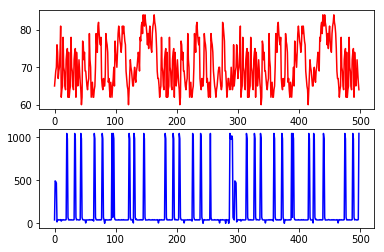

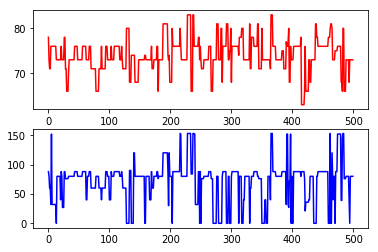

In [120]:
tabnote=[]
tabduree=[]

tabnoteout=[]
tabdureeout=[]

for i in range (1,500):
    tabnote.append(note[i])
    tabduree.append(duree[i])

plt.figure(1)
plt.subplot(211)
plt.plot(tabnote,'r')

plt.subplot(212)
plt.plot(tabduree,'b')
plt.show()

#plot des sorties :
i=0
for n in nw.output_text:
    if i<500:
        tabnoteout.append(n[0])
        i=i+1

i=0
for n in nw.output_text:
    if i<500:
        tabdureeout.append(n[1])
        i=i+1

plt.figure(2)
plt.subplot(211)
plt.plot(tabnoteout,'r')

plt.subplot(212)
plt.plot(tabdureeout,'b')
plt.show()